In [15]:
#pip install pyflux

In [3]:
import numpy as np
import pandas as pd
import json
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pyflux as pf
 
plt.style.use('seaborn-darkgrid')

In [4]:
DATA_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/covid_data/COVID-19-Poland.csv'

In [5]:
#dowloading data from url
data = pd.read_csv(DATA_URL)
data.tail(15)

,day,cases,cases_per_mln_cum,deaths,recovered,tests,positives,positives_tests_ratio,hospitalized,quaran,supervised,deaths_recovered_ratio
251,2020-11-09,21713,14803.0,173,10008,54701,25454,0.465330,21640,407486,37655,0.017286
252,2020-11-10,25454,15466.2,330,11290,53274,25221,0.473420,21521,431104,36263,0.029229
253,2020-11-11,25221,16123.3,429,12214,57249,22683,0.396217,21899,404352,27706,0.035124
254,2020-11-12,22683,16714.3,275,11474,57552,24051,0.417900,22298,430310,30420,0.023967
255,2020-11-13,24051,17341.0,419,13231,56084,25571,0.455941,22320,440025,30625,0.031668
256,2020-11-14,25571,18007.2,548,14635,46607,21854,0.468900,21988,409322,29920,0.037444
257,2020-11-15,21854,18576.7,303,12568,35105,20816,0.592964,22458,422767,28528,0.024109
258,2020-11-16,20816,19119.0,143,11239,41983,19152,0.456185,23033,415174,25618,0.012724
259,2020-11-17,19152,19618.0,357,18260,57012,19883,0.348751,22812,415601,25653,0.019551
260,2020-11-18,19883,20136.1,603,18601,58011,23975,0.413284,22536,434034,24717,0.032418


In [6]:
#Taking the most import columns  (from correlation matrix)
data['day'] = pd.to_datetime(data['day'])
data1= data[data['day']>'2020-11-11']
data1 = data1[data1['day']<'2020-11-21']
data = data[data['day']>'2020-10-01']
data = data[data['day']<'2020-11-13']
data = data[['day', 'cases','deaths_recovered_ratio']]
data.columns = ['date', 'cases','deaths_recovered_ratio']
data.index = data['date'];
data.drop(columns=['date'],inplace=True)
data.head()

,cases,deaths_recovered_ratio
date,,
2020-10-02,2292,0.028361
2020-10-03,2367,0.039720
2020-10-04,1934,0.032746
2020-10-05,2006,0.052823
2020-10-06,2236,0.095710


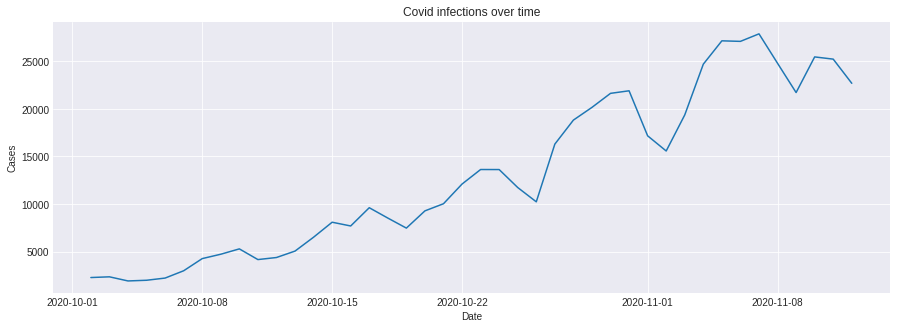

In [7]:

plt.figure(figsize=(15,5))
plt.plot(data.index,data['cases'])
plt.ylabel('Cases')
plt.xlabel('Date')
plt.title('Covid infections over time');

## ARIMAX

In [8]:
# trying out an example parameters
model = pf.ARIMAX(data=data, formula='cases~1+deaths_recovered_ratio',
                  ar=3, integ= 2, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()


Normal ARIMAX(3,2,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced Differenced cases       Method: MLE                                       
Start Date: 2020-10-05 00:00:00                         Log Likelihood: -327.203                          
End Date: 2020-11-12 00:00:00                           AIC: 668.406                                      
Number of observations: 37                              BIC: 679.6824                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1731     0.1652     1.0478   0.2947   (-0.1507 | 0.497)        
AR(2)                                

0 1 0


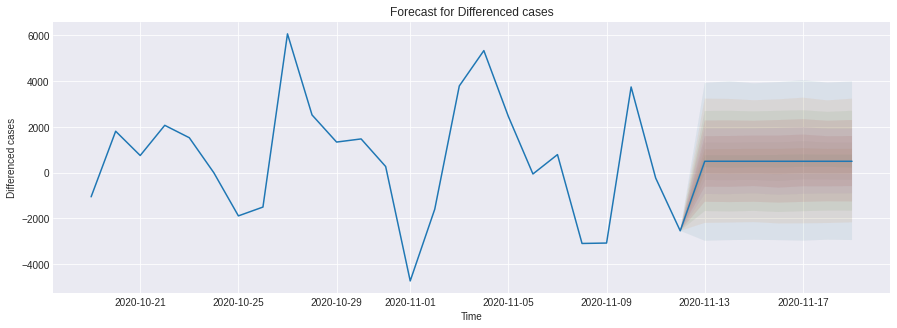

0 1 1


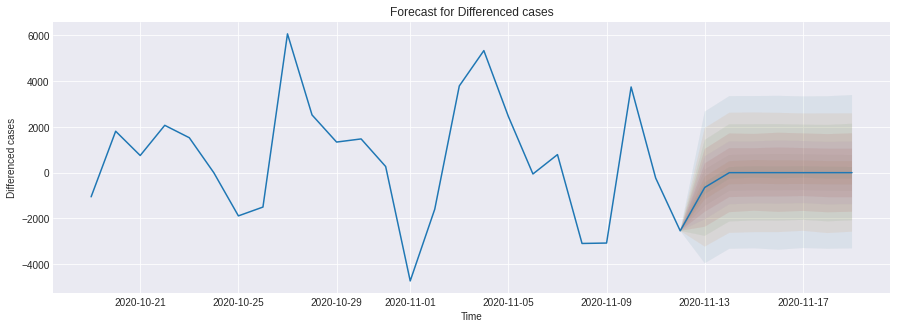

0 1 2


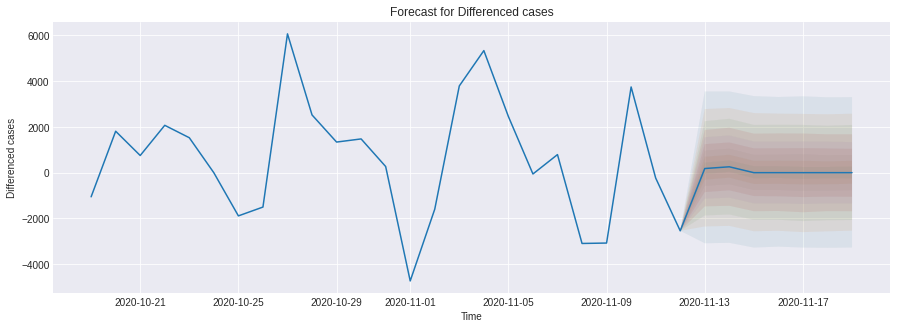

0 1 3


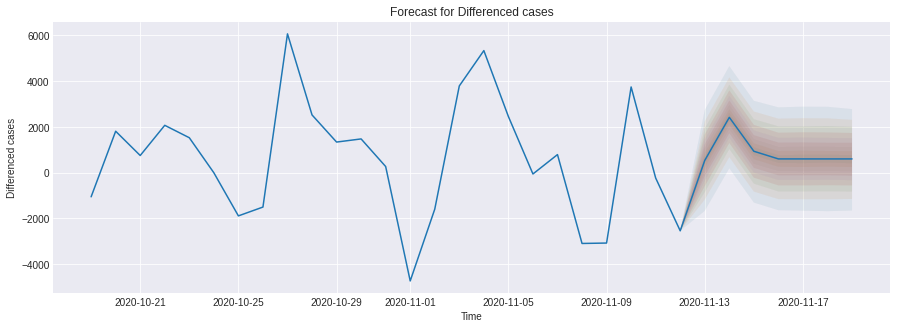

0 1 4


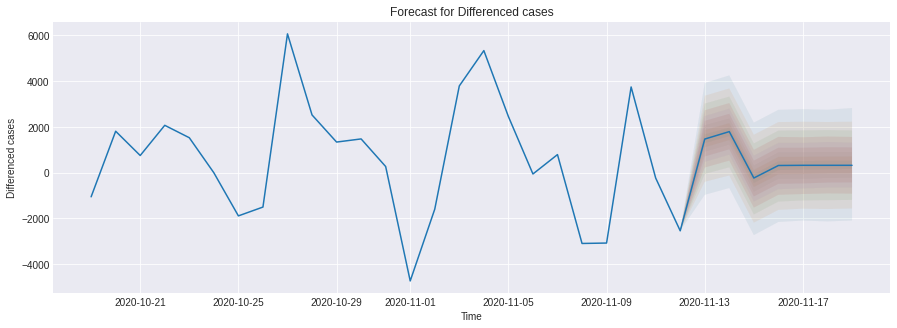

0 2 0


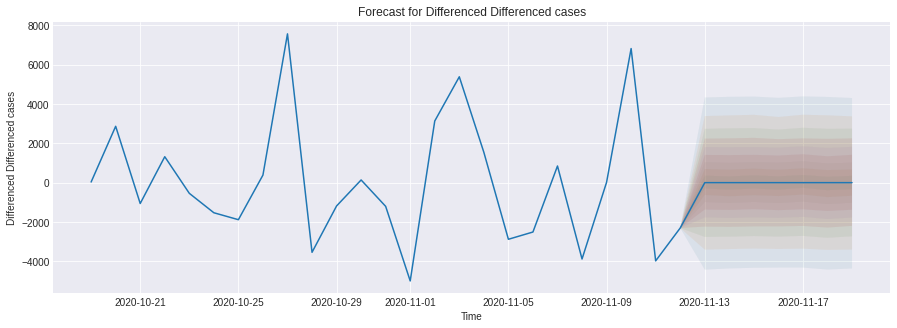

0 2 1


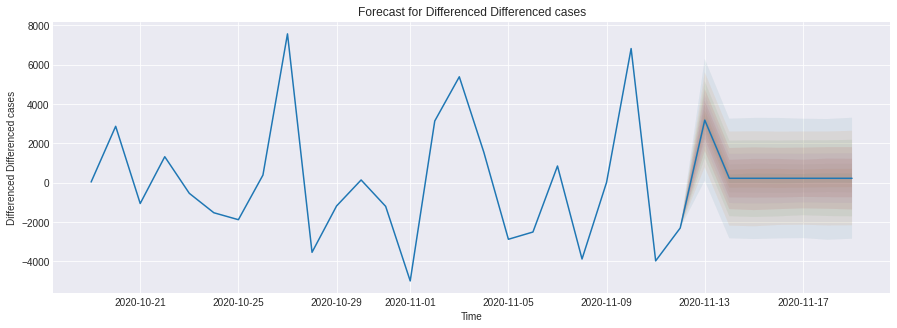

0 2 2


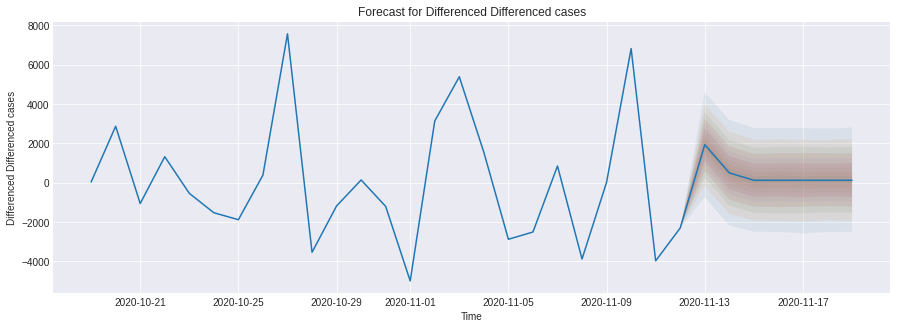

0 2 3


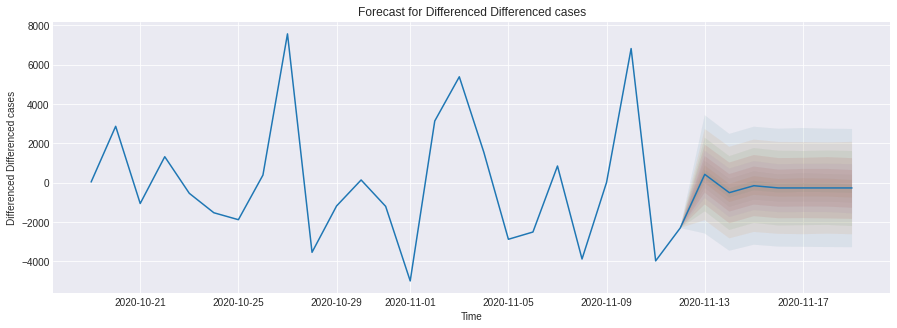

0 2 4


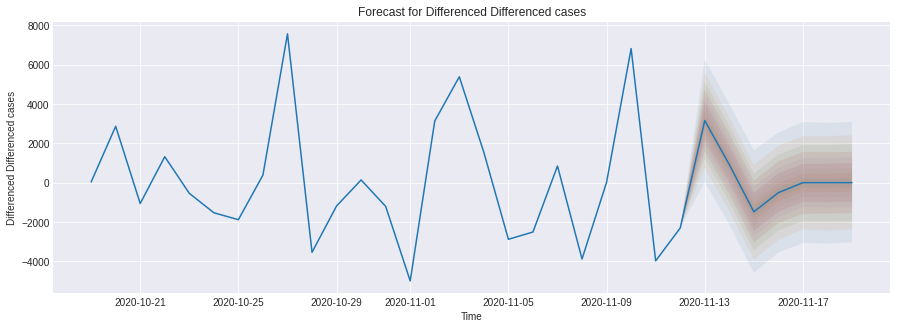

1 1 0


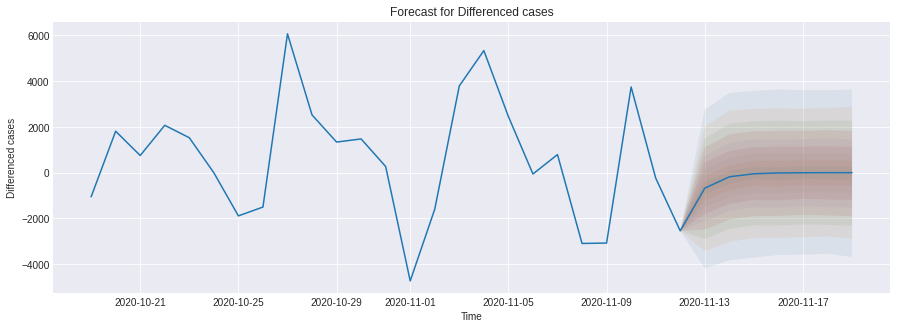

1 1 1


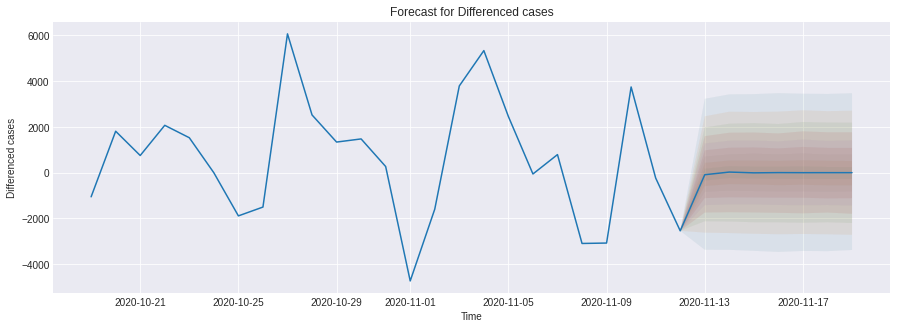

1 1 2


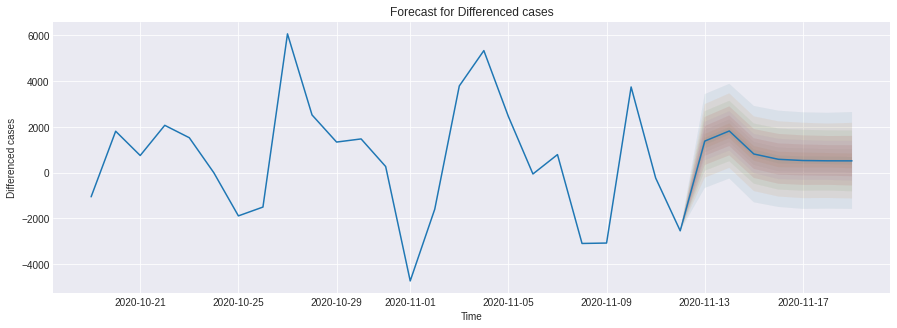

1 1 3


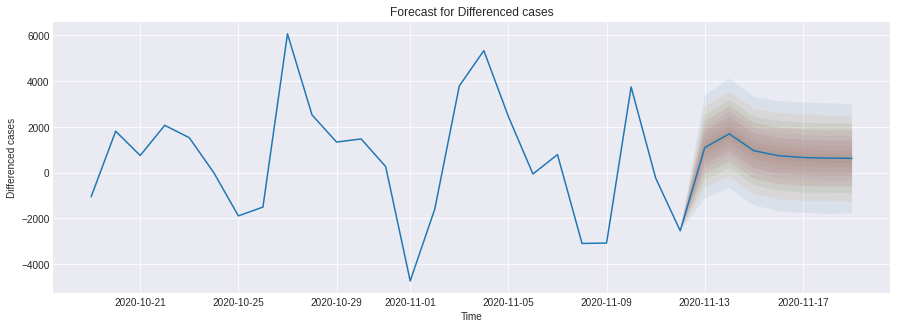

1 1 4


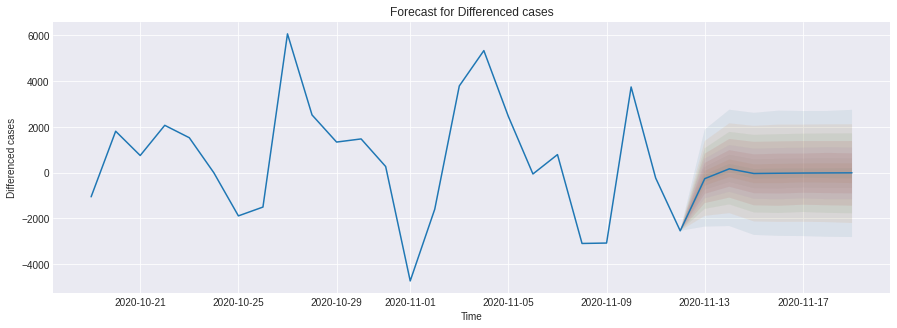

1 2 0


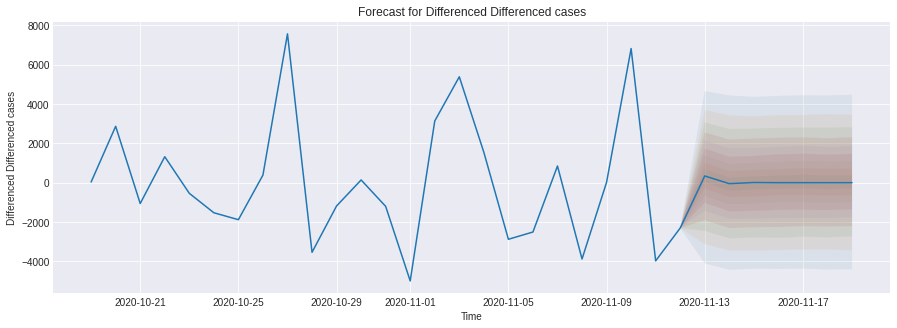

1 2 1


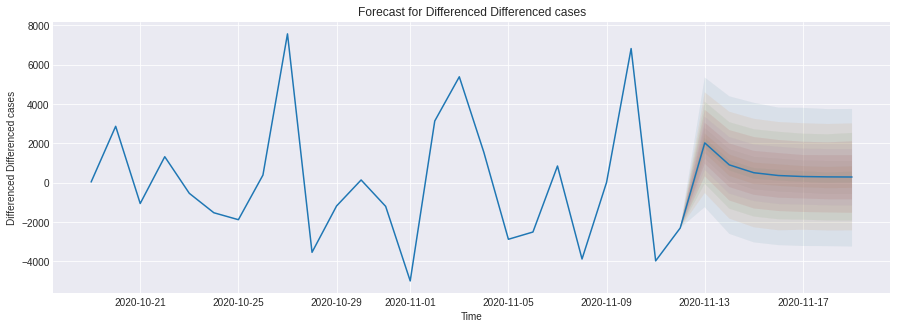

1 2 2


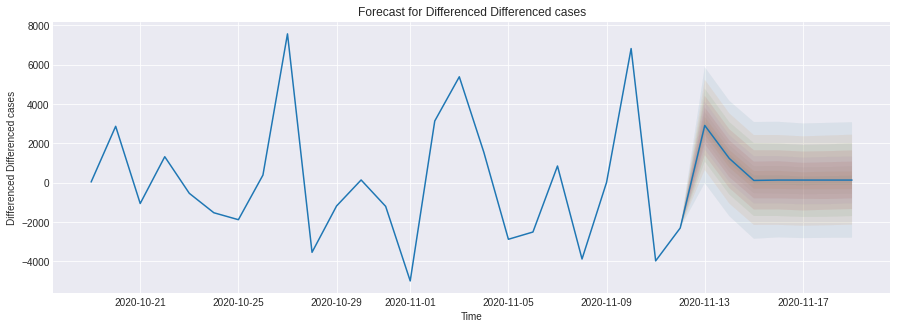

1 2 3


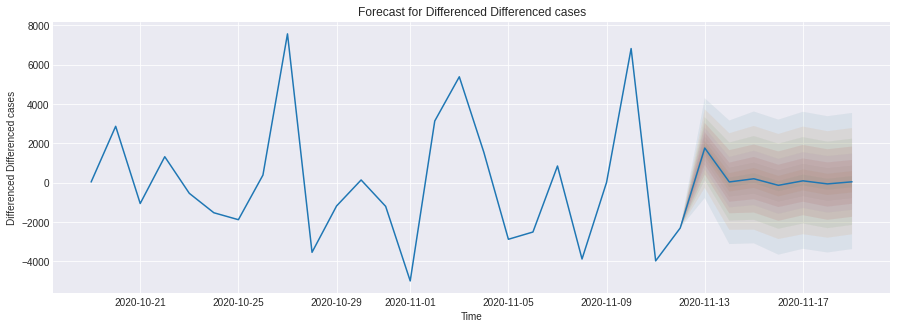

1 2 4


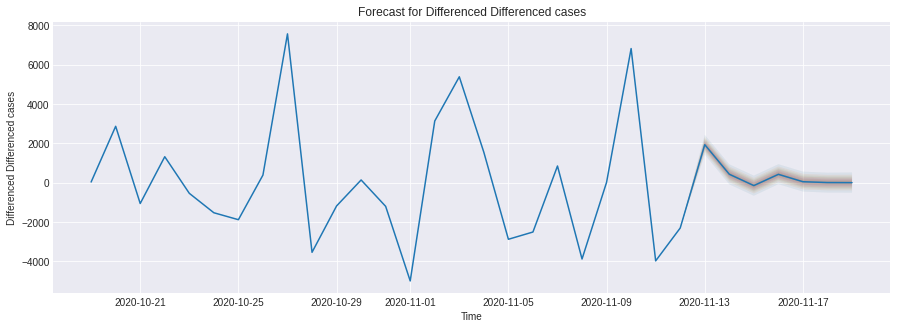

2 1 0


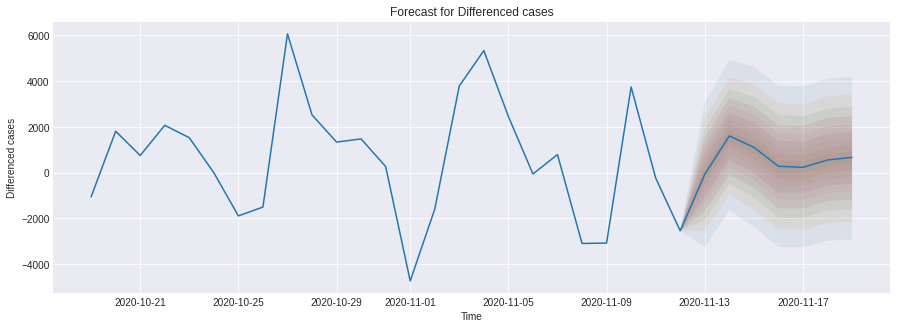

2 1 1


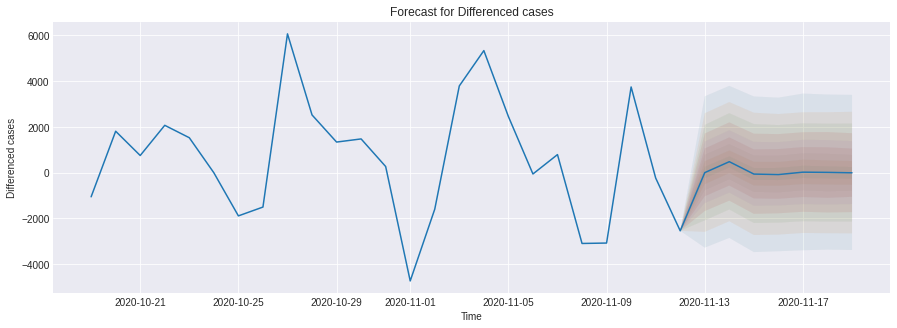

2 1 2


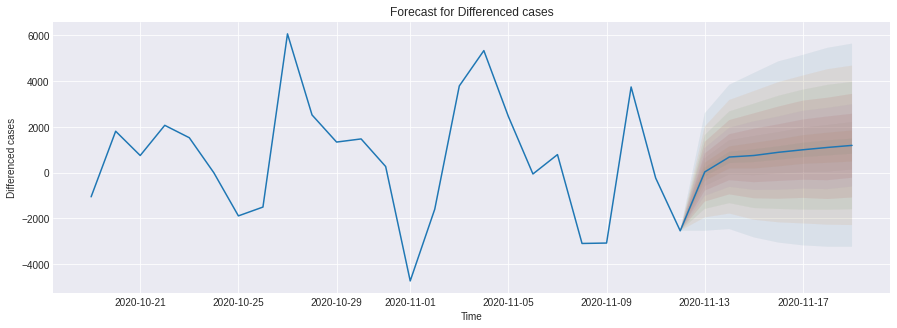

2 1 3


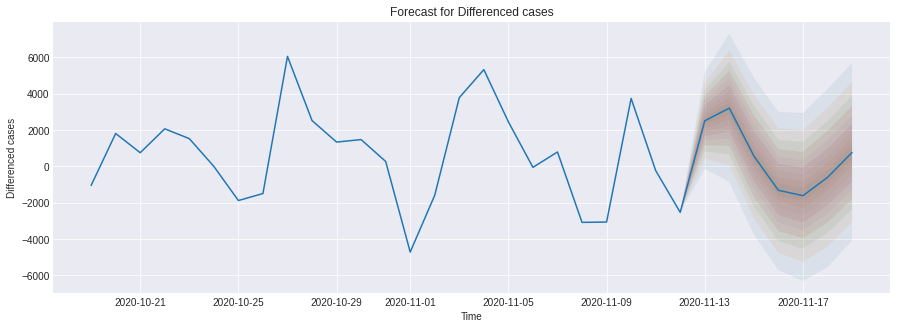

2 1 4


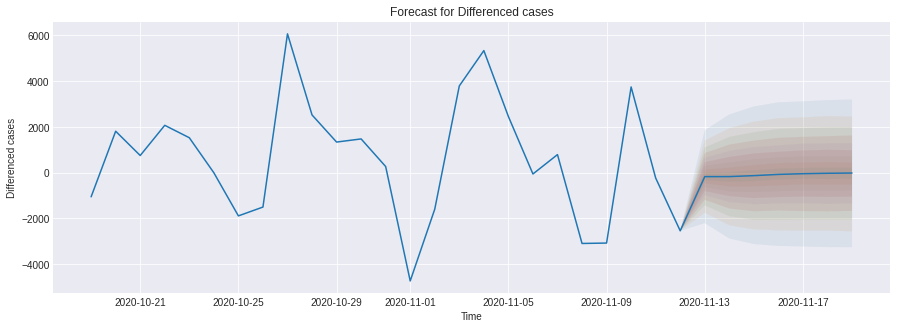

2 2 0


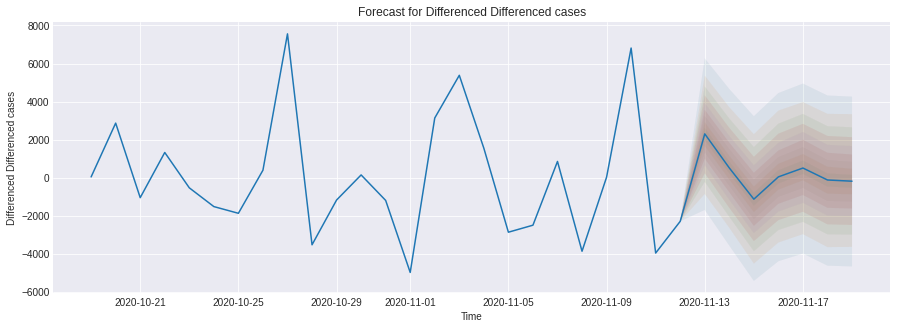

2 2 1


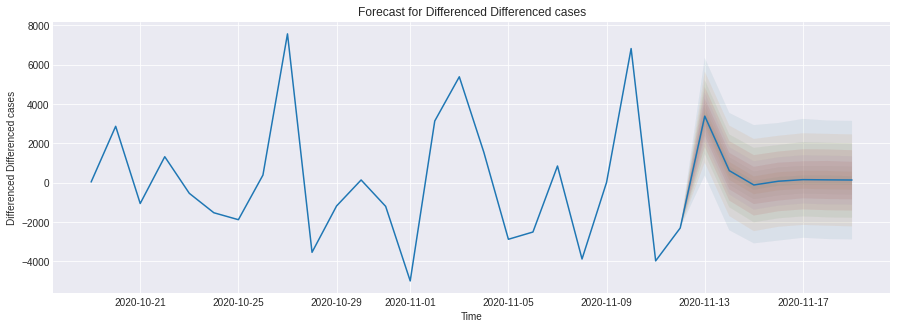

2 2 2


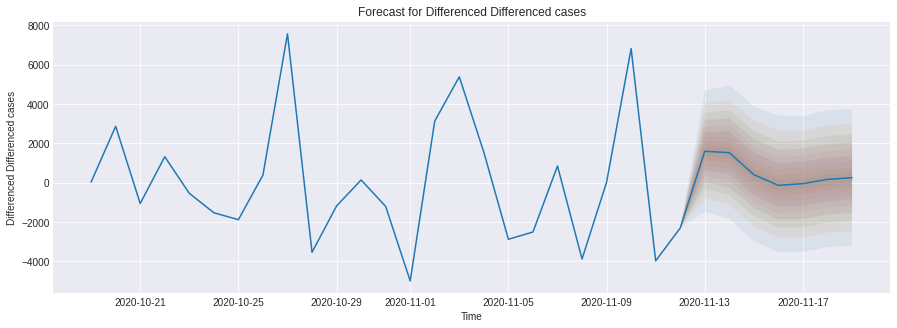

2 2 3


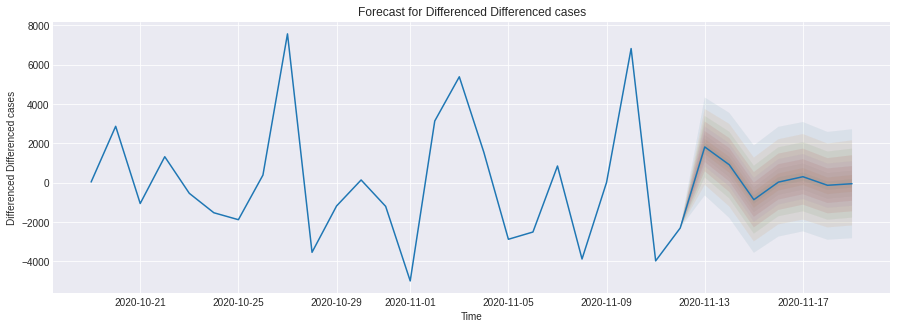

2 2 4


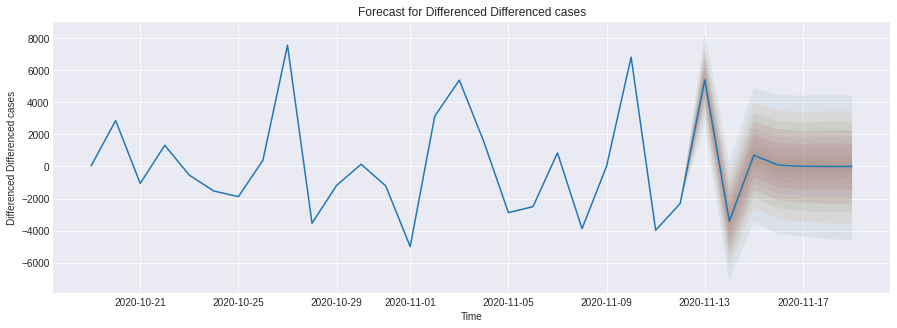

3 1 0


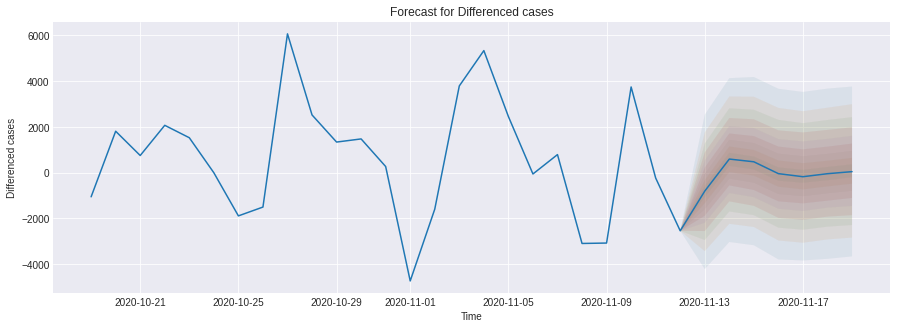

3 1 1


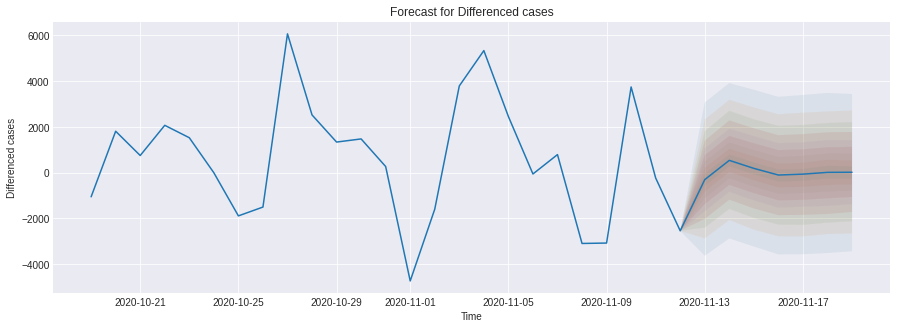

3 1 2


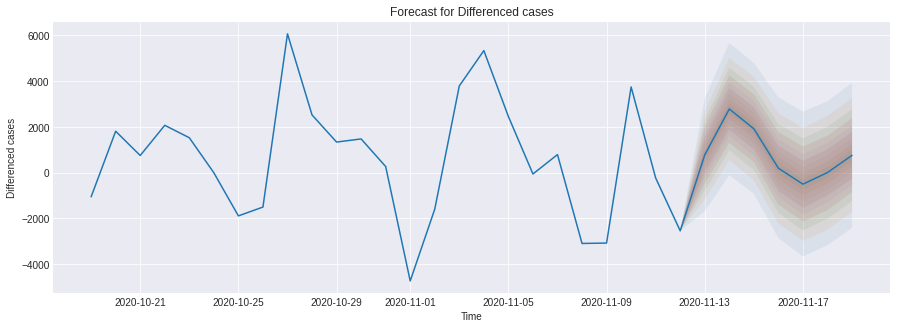

3 1 3


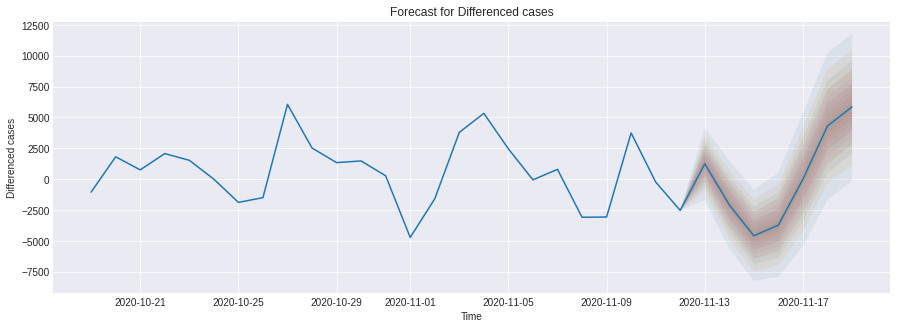

3 1 4


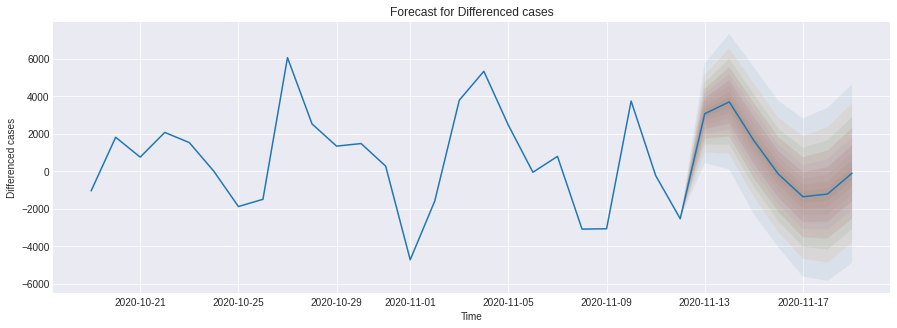

3 2 0


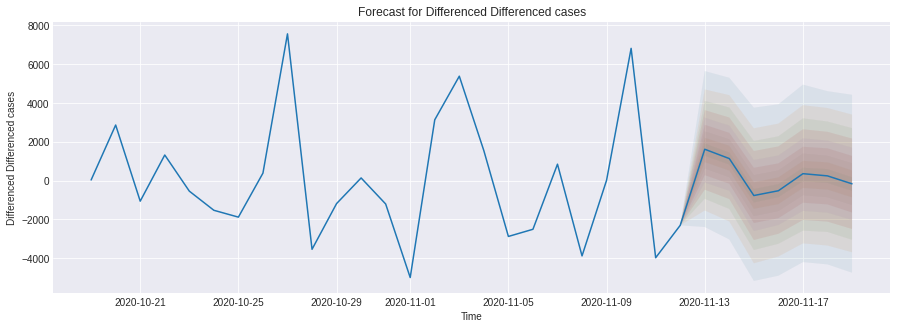

3 2 1


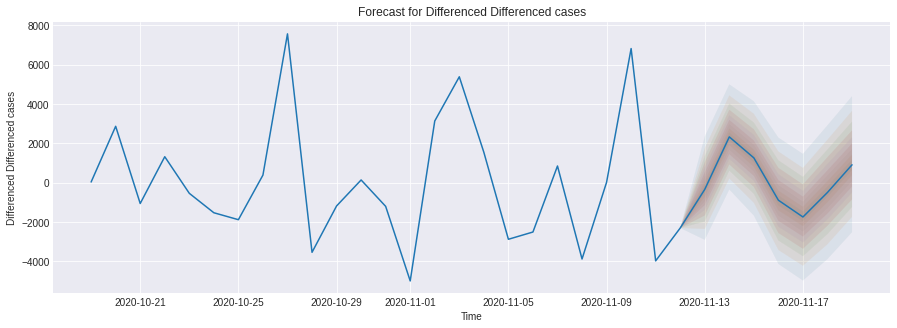

3 2 2


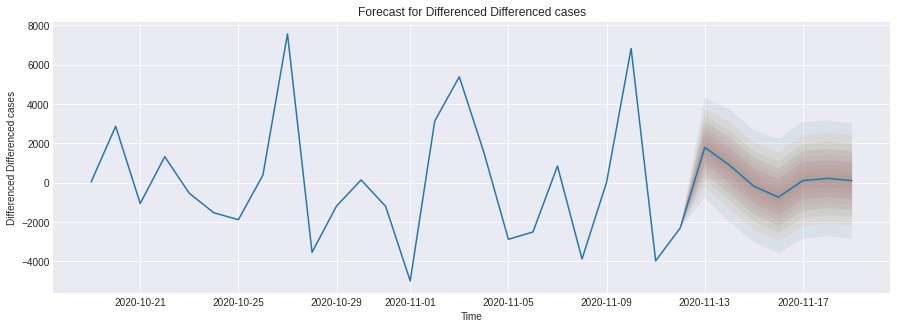

3 2 3


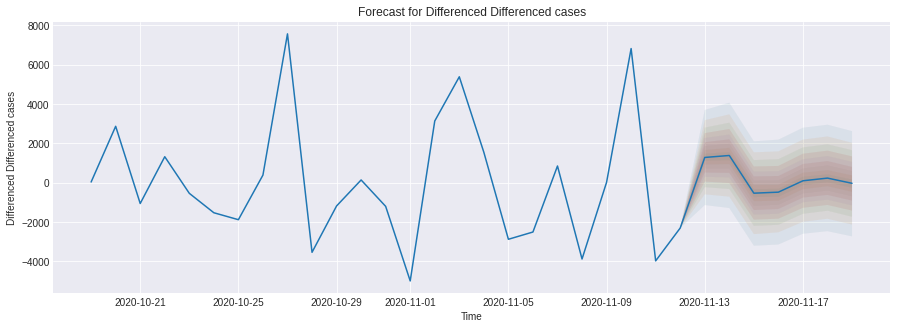

3 2 4


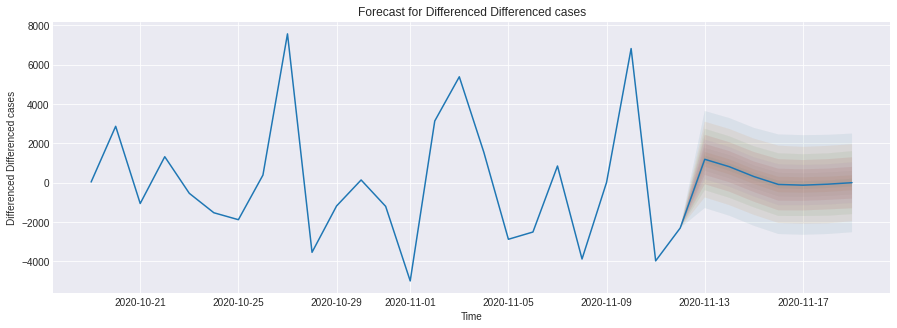

4 1 0


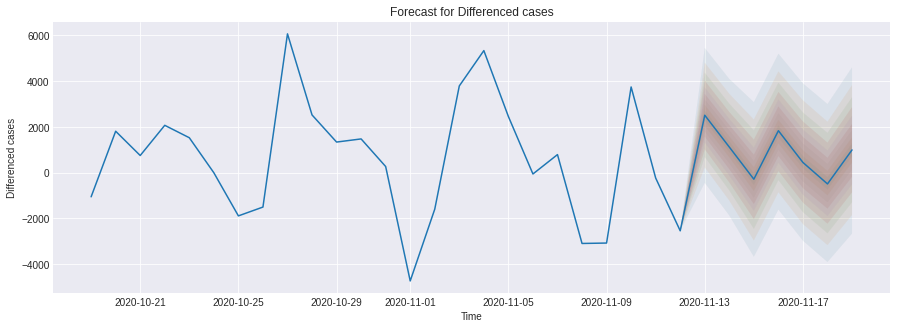

4 1 1


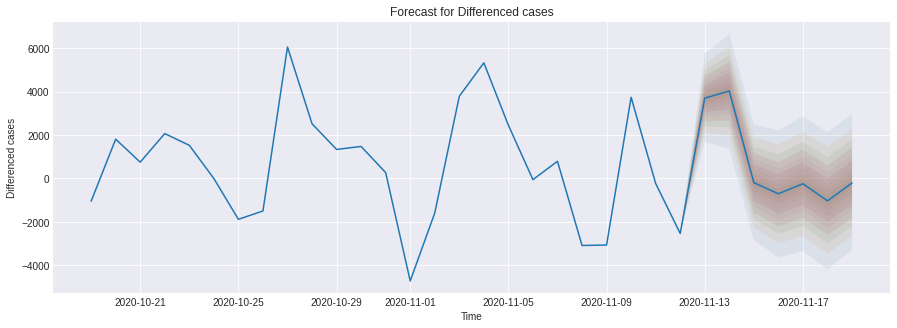

4 1 2


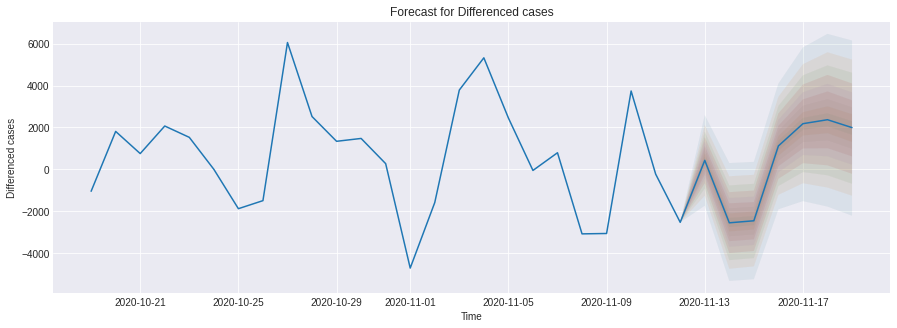

4 1 3


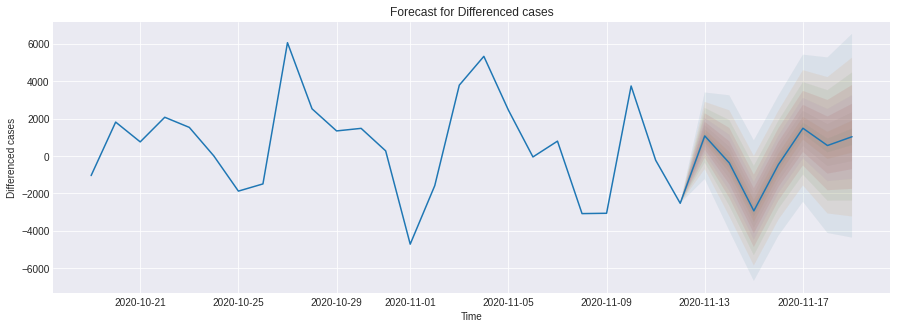

4 1 4


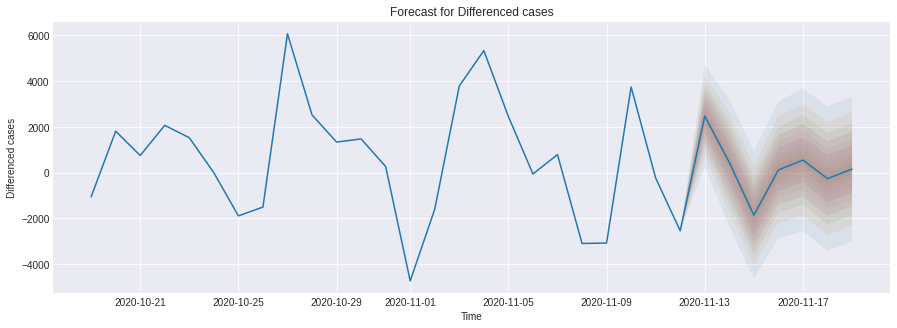

4 2 0


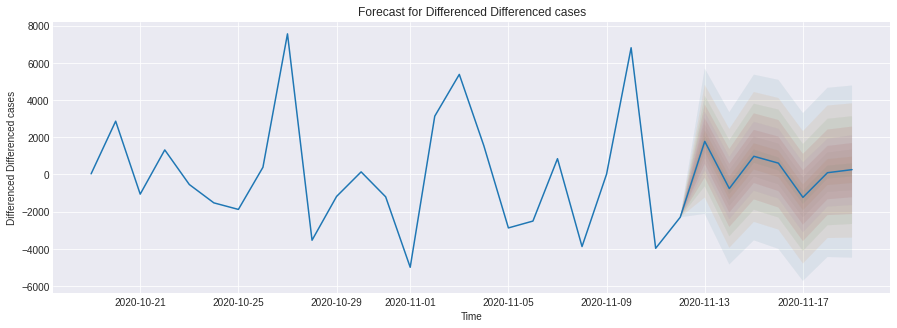

4 2 1


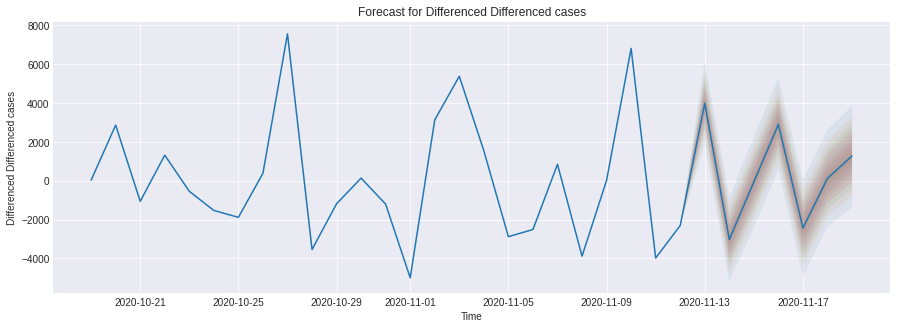

4 2 2


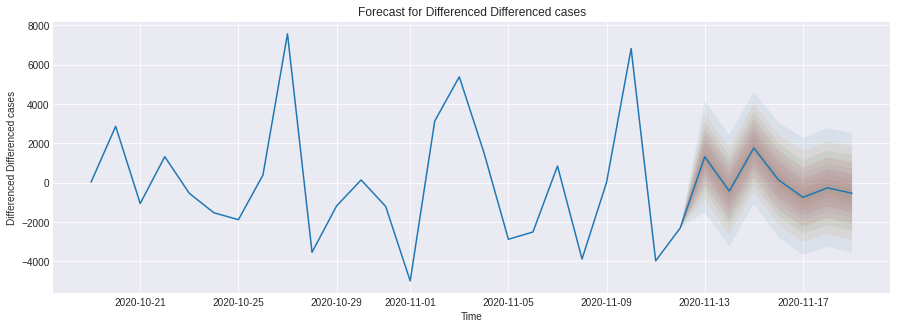

4 2 3


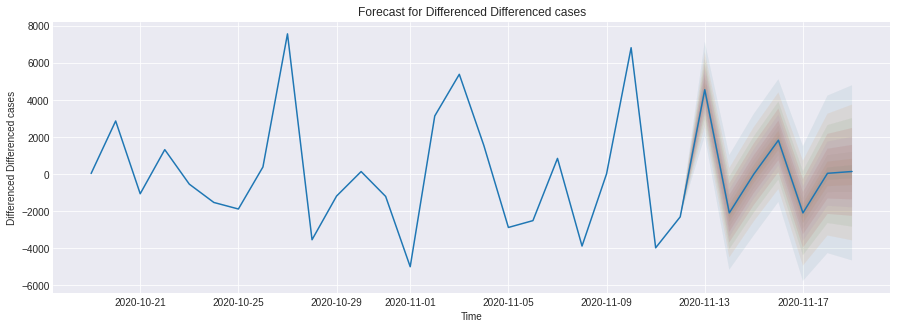

4 2 4


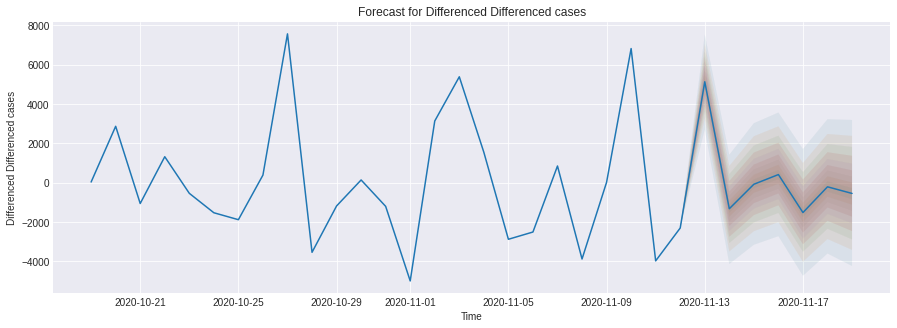

In [9]:
#plotting all near set of parameters
for i in range(5):
  for j in range(1,3):
    for k in range(5):
      model = pf.ARIMAX(data=data, formula='cases~1+deaths_recovered_ratio',
                  ar=i, integ= j, ma=k, family=pf.Normal())
      x = model.fit("MLE")
      #model.plot_fit(figsize=(15,10))
      print(i,j,k)
      model.plot_predict(h=7, oos_data=data.iloc[-9:], past_values=25,figsize=(15,5))

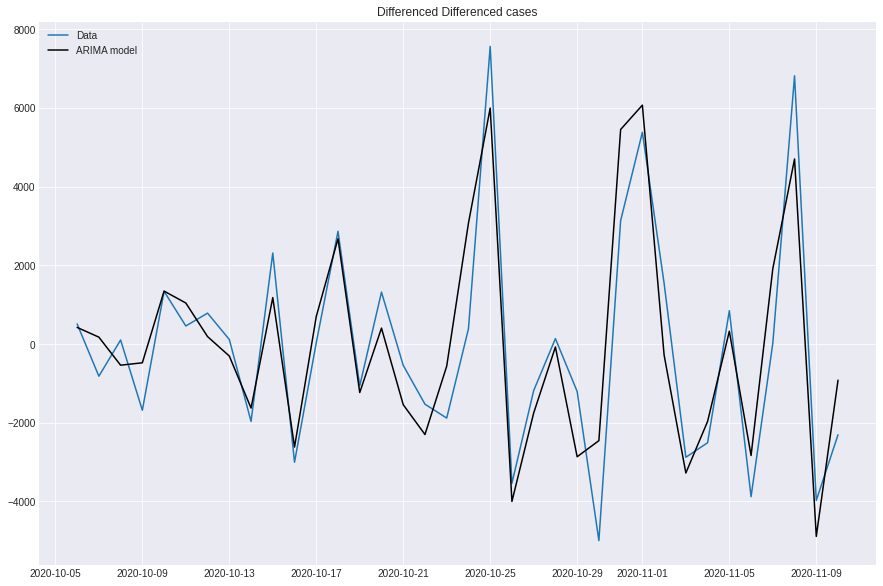

In [11]:
#checking if the data fits
model.plot_fit(figsize=(15,10))

In [13]:
plt.figure(figsize=(15,10))
prediction=model.predict(h=8, oos_data=data.iloc[-10:])
prediction

,Differenced Differenced cases
date,
2020-11-13,5125.275600
2020-11-14,-1324.836770
2020-11-15,-81.819952
2020-11-16,410.581039
2020-11-17,-1519.799609
2020-11-18,-211.253029
2020-11-19,-547.988229
2020-11-20,-151.275535


<Figure size 1080x720 with 0 Axes>

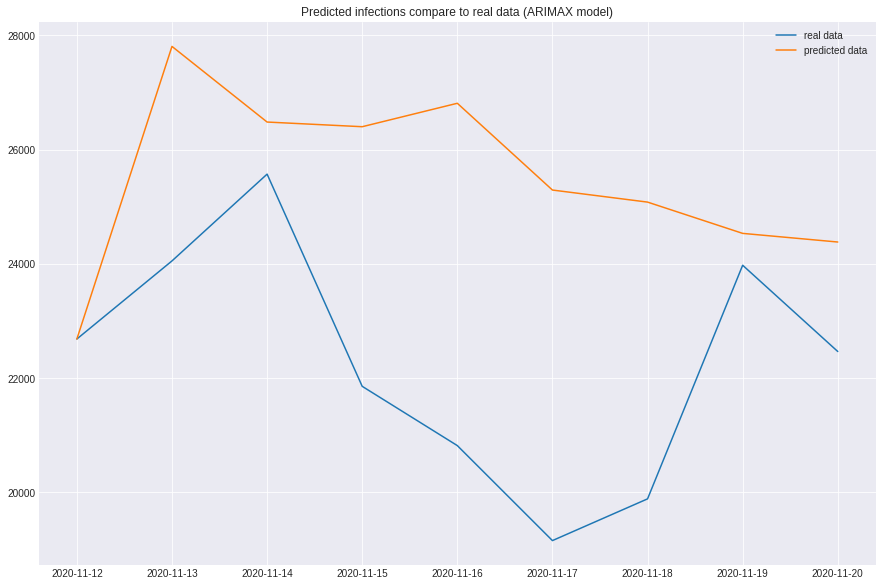

In [14]:
# inserting the starting value and prediction a week ahead
pred=prediction.to_numpy()
pred=np.insert(pred,0,22683)

pred=np.cumsum(pred)
plt.figure(figsize=(15,10))
plt.plot(data1['day'],data1['cases'],label="real data")
dates=pd.date_range(start="2020-11-12",end="2020-11-20")
plt.plot(dates,pred,label="predicted data")
plt.title("Predicted infections compare to real data (ARIMAX model)")
plt.legend()
